# Feux de forêt

Projet Python de 2A à l'ENSAE portant sur l'étude des feux de forêt en France.

# I. Récupération et traitement des données

Ce notebook concerne la partie 1 du projet : récupération et traitement des données.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import urllib
import os
from datetime import datetime, timedelta

On récupère les données sur le site de Météo-France. Les données disponibles complètes sur l'année sont de 1997 à 2019.
https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32

Voici notre fonction pour télécharger les données :

In [30]:
def download_data_meteo():
    
    for k in range(1997,2020):
        for i in range(1,13):

            if i <= 9:
                month = '0' + str(i)
            else:
                month = str(i)

            file_date = str(k) + month
            file_url = 'https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/Archive/synop.' + file_date + '.csv.gz'
            output_file_name = file_date + '.csv.gz'

            if os.path.exists('bdd_meteo') == 0:
                os.mkdir('bdd_meteo') 

            urllib.request.urlretrieve (file_url, 'bdd_meteo/' + output_file_name)
    
    return 'Téléchargement terminé !'    

Test d'un fichier en ouverture :

In [31]:
pd.read_csv('bdd_meteo/200202.csv.gz', sep = ';')

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
0,7005,20020201000000,101540,20,3,210,7.200000,281.850000,280.650000,92,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
1,7015,20020201000000,101520,-20,5,200,8.700000,281.450000,279.450000,87,...,7,3,3000,mq,mq,mq,mq,mq,mq,NaN
2,7020,20020201000000,101500,180,2,220,9.800000,283.650000,283.050000,96,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
3,7027,20020201000000,101770,380,1,240,5.100000,282.450000,280.550000,88,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
4,7037,20020201000000,101690,10,3,250,8.200000,282.450000,281.850000,96,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12891,78922,20020228210000,101350,-70,5,80,4.100000,298.750000,290.650000,61,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
12892,81401,20020228210000,100980,mq,mq,50,5.100000,300.750000,296.350000,77,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
12893,81405,20020228210000,100970,mq,mq,70,4.100000,299.750000,297.050000,85,...,4,8,660,5,3,3000,mq,mq,mq,NaN
12894,81415,20020228210000,100960,mq,mq,mq,mq,298.150000,296.950000,93,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN


Nous voyons que les fichiers bruts ont énormément de colonnes avec des noms peu clairs. Il y a également beaucoup de NaN (ici 'mq') que nous devrons traiter.

Voici la fonction pour traiter un fichier :

In [32]:
def cleaned_csv_meteo(year, month):
    
    if month <= 9:
        file = 'bdd_meteo/' + str(year) + '0' + str(month) + '.csv.gz'
    
    else:
        file = 'bdd_meteo/' + str(year) + str(month) + '.csv.gz'
        
    #ouvrir le fichier   
    df_file = pd.read_csv(file, sep=';')
    
    #sélectionner et renommer les colonnes
    df_file = df_file.rename(columns={'numer_sta':'Station', 'date':'Date', 't':'Température (°C)', 'rr3':'Précipitations (3 heures)', 'u':'Humidité (%)', 'ff':'Vitesse du vent (m/s)'})
    df_file = df_file[['Station', 'Date', 'Température (°C)', 'Précipitations (3 heures)', 'Humidité (%)', 'Vitesse du vent (m/s)']]
    
    #modifier le format de la date et l'heure
    df_file['Date'] = df_file['Date'].apply(lambda x: datetime(year = int(str(x)[0:4]), month = int(str(x)[4:6]), day = int(str(x)[6:8]), hour = int(str(x)[8:10])))
    
    #convertir les Kelvin en degrés Celsius
    l = list(df_file['Température (°C)'])
    for i in range(len(l)):
        if l[i] != 'mq':
            df_file.loc[i, 'Température (°C)'] = float(l[i]) - 273.15
    
    #trier par station et date ainsi que reset l'index
    df_file = df_file.sort_values(['Station', 'Date']).reset_index(drop = True)
    
    return df_file

Voici un exemple du résultat :

In [33]:
cleaned_csv_meteo(2002,2)

,Station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,7005,2002-02-01 00:00:00,8.7,0.800000,92,7.200000
1,7005,2002-02-01 03:00:00,9,0.000000,90,6.200000
2,7005,2002-02-01 06:00:00,9.1,mq,86,6.200000
3,7005,2002-02-01 09:00:00,11.1,0.200000,88,8.200000
4,7005,2002-02-01 12:00:00,13.3,mq,78,10.800000
...,...,...,...,...,...,...
12891,89642,2002-02-28 09:00:00,-7.8,mq,52,8.700000
12892,89642,2002-02-28 12:00:00,-8.4,mq,50,13.900000
12893,89642,2002-02-28 15:00:00,-7.4,mq,56,9.800000
12894,89642,2002-02-28 18:00:00,-7.7,mq,75,15.900000


Il ne reste plus qu'à regrouper tous les fichiers mensuels en un seul dataframe :

In [34]:
def concat_meteo(year_begin, year_end):
    
    df_meteo = pd.DataFrame()

    for k in range(year_begin, year_end + 1):
        for i in range(1,13):       
            df_meteo = pd.concat([df_meteo, cleaned_csv_meteo(k,i)], ignore_index = True)

    return df_meteo

In [35]:
#lignes de commande pour enregistrer le fichier 'data_meteo.csv'
#df_meteo = concat_meteo(2006,2019)
#df_meteo.to_csv('data_meteo.csv', index = False)

In [36]:
df_meteo = pd.read_csv('data_meteo.csv')
df_meteo

,Station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,7005,2006-01-01 00:00:00,4.0,2.000000,92,5.100000
1,7005,2006-01-01 03:00:00,3.7000000000000455,0.000000,91,4.100000
2,7005,2006-01-01 06:00:00,3.1000000000000227,3.000000,92,5.100000
3,7005,2006-01-01 09:00:00,4.7000000000000455,0.600000,96,3.100000
4,7005,2006-01-01 12:00:00,6.100000000000023,2.000000,94,5.100000
...,...,...,...,...,...,...
2357361,89642,2019-12-31 00:00:00,0.7000000000000455,mq,62,28.300000
2357362,89642,2019-12-31 12:00:00,1.7000000000000455,mq,74,23.100000
2357363,89642,2019-12-31 15:00:00,1.0,mq,78,18.000000
2357364,89642,2019-12-31 18:00:00,1.0,mq,72,20.600000


**On va désormais relier les stations météos à une position sur la carte de France**

Les fichiers 'postesSynop.txt' et 'postesSynop.json' ont été trouvés sur le site de Météo-France. Ils comportent les caractéristiques des stations météo.

In [37]:
stations = pd.read_csv('postesSynop.txt', sep = ';')
stations

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151
...,...,...,...,...,...
57,81401,SAINT LAURENT,5.485500,-54.031667,5
58,81405,CAYENNE-MATOURY,4.822333,-52.365333,4
59,81408,SAINT GEORGES,3.890667,-51.804667,6
60,81415,MARIPASOULA,3.640167,-54.028333,106


In [38]:
stations_geo = gpd.read_file('postesSynop.json')
stations_geo

,ID,Nom,Latitude,Longitude,Altitude,geometry
0,07005,ABBEVILLE,50.136000,1.834000,69,POINT (1.83400 50.13600)
1,07015,LILLE-LESQUIN,50.570000,3.097500,47,POINT (3.09750 50.57000)
2,07020,PTE DE LA HAGUE,49.725167,-1.939833,6,POINT (-1.93983 49.72517)
3,07027,CAEN-CARPIQUET,49.180000,-0.456167,67,POINT (-0.45617 49.18000)
4,07037,ROUEN-BOOS,49.383000,1.181667,151,POINT (1.18167 49.38300)
...,...,...,...,...,...,...
57,81401,SAINT LAURENT,5.485500,-54.031667,5,POINT (-54.03167 5.48550)
58,81405,CAYENNE-MATOURY,4.822333,-52.365333,4,POINT (-52.36533 4.82233)
59,81408,SAINT GEORGES,3.890667,-51.804667,6,POINT (-51.80467 3.89067)
60,81415,MARIPASOULA,3.640167,-54.028333,106,POINT (-54.02833 3.64017)


On utilise également la base de données des villes françaises pour obtenir les coordonnées spatiales des villes. Nous allons en avoir besoin pour relier les villes des feux à la station météo la plus proche.

On traite ces données pour obtenir seulement les informations dont on a besoin. On traite aussi le texte en enlevant les tirets et slash.

In [45]:
villes = pd.read_csv('villes_france.csv',sep = ',', low_memory = False)
villes = villes.iloc[:, [1,3,8,19,20]]
villes.columns = ['Département', 'Nom', 'Code postal', 'Longitude', 'Latitude']
villes = villes.dropna(axis = 0, subset = ['Département', 'Nom'])
villes['Nom'] = villes['Nom'].str.replace('-', ' ')
villes['Nom'] = villes['Nom'].str.replace('\'', ' ')
villes

,Département,Nom,Code postal,Longitude,Latitude
0,01,CORMORANCHE SUR SAONE,01290,4.83333,46.23330
1,01,PLAGNE,01130,5.73333,46.18330
2,01,TOSSIAT,01250,5.31667,46.13330
3,01,POUILLAT,01250,5.43333,46.33330
4,01,TORCIEU,01230,5.40000,45.91670
...,...,...,...,...,...
36694,976,SADA,97640,45.10470,-12.84860
36695,976,TSINGONI,97680,45.10700,-12.78970
36696,971,SAINT BARTHELEMY,97133,-62.83330,17.91670
36697,971,SAINT MARTIN,97150,18.09130,-63.08290


On utilise la base de données BDIFF pour les feux de forêt
https://bdiff.agriculture.gouv.fr/incendies

In [46]:
df_feu = pd.read_csv('data_feux.csv', sep = ';', skiprows = [0,1,2,3,4])
df_feu = df_feu.dropna(axis = 0, subset = ['Département', 'Commune'])
import unidecode
df_feu['Commune'] = df_feu['Commune'].apply(lambda row: unidecode.unidecode(row))
df_feu['Commune'] = df_feu['Commune'].apply(lambda row: row.upper())
df_feu['Commune'] = df_feu['Commune'].str.replace('-', ' ')
df_feu['Commune'] = df_feu['Commune'].str.replace('\'', ' ')
df_feu

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Statut
0,2006,2,01,01148,DORTAN,2006-02-27 13:56:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force
1,2006,3,01,01321,REVONNAS,2006-03-15 16:02:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force
2,2006,4,01,01032,BELIGNEUX,2006-03-16 17:03:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force
3,2006,5,01,01109,COLLONGES,2006-03-27 14:30:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force
4,2006,6,01,01384,SAINT RAMBERT EN BUGEY,2006-04-24 16:43:00,20000,0,20000,0.0,0.0,0,NaN,Validé en force
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36323,2019,5755,2B,2B183,OGLIASTRO,2019-01-03 16:40:00,1500,1500,0,NaN,NaN,0,NaN,Validé
36324,2019,5756,2B,2B235,PIOGGIOLA,2019-01-02 14:35:00,8000,8000,0,NaN,NaN,0,NaN,Validé
36325,2019,5757,06,06074,LANTOSQUE,2019-01-05 16:10:00,5000,5000,0,NaN,NaN,0,NaN,Validé
36326,2019,5758,34,34130,LAURENS,2019-01-06 17:11:00,1326,1326,0,NaN,NaN,0,NaN,Validé


**Fusion feu/liste des villes afin d'avoir les coordonnées spatiales des villes de chaque feu**

Il n'y a pas de code INSEE pour la bdd des villes et pas de code postal pour la bdd des feux. Le nom de commune ne suffit pas car il y a des homonymes. On crée donc une colomne avec le nom de commune + le numéro de département pour la fusion. 

In [47]:
villes['Clé'] = villes['Département'] + villes['Nom']
villes = villes.drop(columns = ['Département', 'Nom'])
df_feu['Clé'] = df_feu['Département'] + df_feu['Commune']

In [48]:
#jointure feu/ville

df_feu_villes = pd.merge(df_feu, villes, on = 'Clé', how ='inner')
df_feu_villes = df_feu_villes.drop(columns = 'Clé')
df_feu_villes

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Statut,Code postal,Longitude,Latitude
0,2006,2,01,01148,DORTAN,2006-02-27 13:56:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force,01590,5.66667,46.3167
1,2006,3,01,01321,REVONNAS,2006-03-15 16:02:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force,01250,5.33333,46.1667
2,2006,4,01,01032,BELIGNEUX,2006-03-16 17:03:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force,01360,5.11667,45.8667
3,2006,5,01,01109,COLLONGES,2006-03-27 14:30:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force,01550,5.90000,46.1333
4,2006,6,01,01384,SAINT RAMBERT EN BUGEY,2006-04-24 16:43:00,20000,0,20000,0.0,0.0,0,NaN,Validé en force,01230,5.43333,45.9500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33270,2019,5655,04,04032,BRAUX,2019-02-25 15:35:00,20800,20800,0,NaN,NaN,0,NaN,Validé,04240,6.68333,43.9833
33271,2019,5660,2B,2B222,PIE D OREZZA,2019-02-24 10:47:00,100000,0,100000,NaN,NaN,0,NaN,Validé,20229,9.35501,42.3723
33272,2019,5667,05,05160,SALERANS,2019-02-23 13:53:00,11000,11000,0,NaN,NaN,0,NaN,Validé,05300,5.70000,44.2500
33273,2019,5669,05,05160,SALERANS,2019-02-20 13:31:00,8000,8000,0,NaN,NaN,0,NaN,Validé,05300,5.70000,44.2500


In [49]:
stations

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151
...,...,...,...,...,...
57,81401,SAINT LAURENT,5.485500,-54.031667,5
58,81405,CAYENNE-MATOURY,4.822333,-52.365333,4
59,81408,SAINT GEORGES,3.890667,-51.804667,6
60,81415,MARIPASOULA,3.640167,-54.028333,106


**Représentation des stations météo :**

In [74]:
import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
    myfile = requests.get(url)
    open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
        zip_ref.extractall(dirname + '/' + destname)

In [75]:
download_unzip("https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12")
communes = gpd.read_file(temporary_location + "/borders/communes-20190101.json")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318,"POLYGON ((-60.93595 14.58812, -60.93218 14.585..."
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325,"POLYGON ((-61.12165 14.71928, -61.11852 14.716..."
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374,"POLYGON ((-61.13355 14.74657, -61.13066 14.748..."
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324,"POLYGON ((-61.08459 14.72510, -61.08430 14.722..."
4,97212,Gros-Morne,fr:Gros-Morne,4601,"POLYGON ((-61.08459 14.72510, -61.08061 14.725..."


(40.0, 52.0)

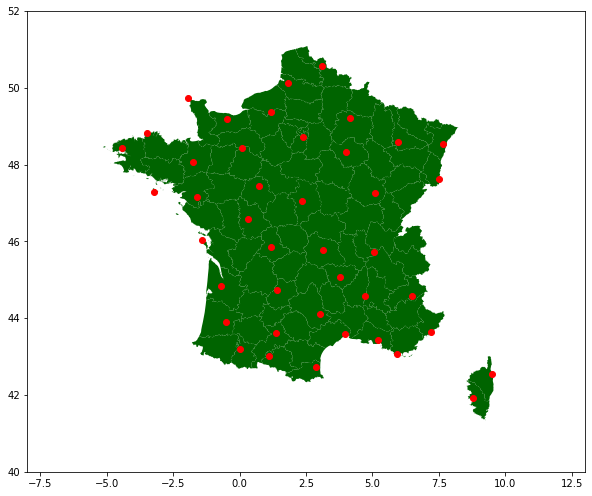

In [77]:
communes['dep'] = communes['insee'].str[:2]
ax = stations_geo.plot(figsize = (10,10), color = 'red', zorder = 2)
fr= communes[communes['dep'] != '97']
fr.dissolve(by='dep').plot(ax = ax, color = 'darkgreen', figsize = (10,10), zorder = 1)
plt.xlim([-8,13])
plt.ylim([40,52])

On voit que les stations sont bien réparties dans toute la France. Ceci permet l'approximation des conditions météo des feux à sa station la plus proche.

Calcul de la distance entre chaque commune de df_feu_villes et chaque station pour trouver la plus proche :

In [50]:
import geopy.distance

In [51]:
def distance(lat1, long1, lat2, long2):
    
    coords_1 = (lat1, long1)
    coords_2 = (lat2, long2)
    
    return(geopy.distance.distance(coords_1, coords_2).km)

In [52]:
def station_la_plus_proche(codeinsee):
    
    sub = df_feu_villes[df_feu_villes['Code INSEE'] == codeinsee]
    L_dist = []
    lat = sub['Latitude'].iloc[0]
    long = sub['Longitude'].iloc[0]
    
    if long is not None and lat is not None:        
        for k in range(stations.shape[0]):
            L_dist.append(distance(lat, long, stations.loc[k, 'Latitude'], stations.loc[k, 'Longitude']))
            
        return stations.iloc[L_dist.index(min(L_dist)), 1]
    
    else: 
        return None 

In [53]:
df_feu_villes['Station la plus proche'] = df_feu_villes['Code INSEE'].apply(lambda row: station_la_plus_proche(row))
df_feu_villes

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Précision des surfaces,Statut,Code postal,Longitude,Latitude,Station la plus proche
0,2006,2,01,01148,DORTAN,2006-02-27 13:56:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force,01590,5.66667,46.3167,LYON-ST EXUPERY
1,2006,3,01,01321,REVONNAS,2006-03-15 16:02:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force,01250,5.33333,46.1667,LYON-ST EXUPERY
2,2006,4,01,01032,BELIGNEUX,2006-03-16 17:03:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force,01360,5.11667,45.8667,LYON-ST EXUPERY
3,2006,5,01,01109,COLLONGES,2006-03-27 14:30:00,10000,0,10000,0.0,0.0,0,NaN,Validé en force,01550,5.90000,46.1333,LYON-ST EXUPERY
4,2006,6,01,01384,SAINT RAMBERT EN BUGEY,2006-04-24 16:43:00,20000,0,20000,0.0,0.0,0,NaN,Validé en force,01230,5.43333,45.9500,LYON-ST EXUPERY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33270,2019,5655,04,04032,BRAUX,2019-02-25 15:35:00,20800,20800,0,NaN,NaN,0,NaN,Validé,04240,6.68333,43.9833,NICE
33271,2019,5660,2B,2B222,PIE D OREZZA,2019-02-24 10:47:00,100000,0,100000,NaN,NaN,0,NaN,Validé,20229,9.35501,42.3723,BASTIA
33272,2019,5667,05,05160,SALERANS,2019-02-23 13:53:00,11000,11000,0,NaN,NaN,0,NaN,Validé,05300,5.70000,44.2500,EMBRUN
33273,2019,5669,05,05160,SALERANS,2019-02-20 13:31:00,8000,8000,0,NaN,NaN,0,NaN,Validé,05300,5.70000,44.2500,EMBRUN


On fusionne df_fdf avec la bdd des stations météo pour avoir dans notre tableau les données des stations.

**Fusion df_fdf et stations**

In [54]:
df_fdf = pd.merge(df_feu_villes, stations, how = 'inner', left_on = 'Station la plus proche', right_on = 'Nom')
df_fdf = df_fdf.drop(columns = 'Nom')
df_fdf = df_fdf.rename(columns={"Longitude_x": "Longitude commune", 
                                  "Latitude_x": "Latitude commune", "ID": "id_station", "Latitude_y": "Latitude station", 
                                  "Longitude_y": "Longitude station", "Altitude": "Altitude station"})
df_fdf = df_fdf.sort_values(by = ['Date de première alerte'])
df_fdf = df_fdf.reset_index(drop = True)
df_fdf

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),...,Précision des surfaces,Statut,Code postal,Longitude commune,Latitude commune,Station la plus proche,id_station,Latitude station,Longitude station,Altitude station
0,2006,4653,66,66179,SAINT LAURENT DE CERDANS,2006-01-01 12:50:00,10000,10000,0,NaN,...,NaN,Validé,66260,2.61667,42.3833,PERPIGNAN,7747,42.737167,2.872833,42
1,2006,4652,66,66190,SALSES LE CHATEAU,2006-01-01 12:56:00,20000,0,20000,NaN,...,NaN,Validé,66600,2.91889,42.8328,PERPIGNAN,7747,42.737167,2.872833,42
2,2006,4554,83,83028,CALLAS,2006-01-01 15:40:00,30,30,0,NaN,...,NaN,Validé,83830,6.53333,43.5833,NICE,7690,43.648833,7.209000,2
3,2006,4552,34,34237,ROUJAN,2006-01-02 18:19:00,37500,10000,27500,NaN,...,NaN,Validé,34320,3.30000,43.5167,MONTPELLIER,7643,43.577000,3.963167,2
4,2006,4553,83,83050,DRAGUIGNAN,2006-01-02 20:57:00,200,200,0,NaN,...,NaN,Validé,83300,6.46667,43.5333,NICE,7690,43.648833,7.209000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33270,2019,4839,06,06050,COURSEGOULES,2019-12-27 14:22:00,5000,5000,0,NaN,...,NaN,Validé,06140,7.03333,43.8000,NICE,7690,43.648833,7.209000,2
33271,2019,4838,06,06151,UTELLE,2019-12-27 14:53:00,4000,4000,0,NaN,...,NaN,Validé,06450,7.25000,43.9167,NICE,7690,43.648833,7.209000,2
33272,2019,2268,40,40225,PHILONDENX,2019-12-28 17:36:00,5,0,5,NaN,...,NaN,Validé,40320,-0.45000,43.5667,MONT-DE-MARSAN,7607,43.909833,-0.500167,59
33273,2019,4074,83,83044,COMPS SUR ARTUBY,2019-12-30 17:05:00,500,500,0,NaN,...,NaN,Validé,83840,6.50000,43.7167,NICE,7690,43.648833,7.209000,2


Pour chaque station, les données météorologiques sont relevées toutes les trois heures (de minuit jusqu'à 21h). 

In [56]:
def plus_proche_relevé(date) :
    "retourne la date de relevé météorologique la plus proche de la date de première alerte du feu"
    
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
   
    relevé_ant = datetime(date.year, date.month, date.day, date.hour//3 *3)
    relevé_post = relevé_ant + timedelta(hours = 3)

    if date - relevé_ant < relevé_post - date : 
        return relevé_ant
    
    return relevé_post 

In [57]:
df_fdf['Date de relevé'] = df_fdf['Date de première alerte'].apply(lambda row: plus_proche_relevé(row))
df_fdf

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),...,Statut,Code postal,Longitude commune,Latitude commune,Station la plus proche,id_station,Latitude station,Longitude station,Altitude station,Date de relevé
0,2006,4653,66,66179,SAINT LAURENT DE CERDANS,2006-01-01 12:50:00,10000,10000,0,NaN,...,Validé,66260,2.61667,42.3833,PERPIGNAN,7747,42.737167,2.872833,42,2006-01-01 12:00:00
1,2006,4652,66,66190,SALSES LE CHATEAU,2006-01-01 12:56:00,20000,0,20000,NaN,...,Validé,66600,2.91889,42.8328,PERPIGNAN,7747,42.737167,2.872833,42,2006-01-01 12:00:00
2,2006,4554,83,83028,CALLAS,2006-01-01 15:40:00,30,30,0,NaN,...,Validé,83830,6.53333,43.5833,NICE,7690,43.648833,7.209000,2,2006-01-01 15:00:00
3,2006,4552,34,34237,ROUJAN,2006-01-02 18:19:00,37500,10000,27500,NaN,...,Validé,34320,3.30000,43.5167,MONTPELLIER,7643,43.577000,3.963167,2,2006-01-02 18:00:00
4,2006,4553,83,83050,DRAGUIGNAN,2006-01-02 20:57:00,200,200,0,NaN,...,Validé,83300,6.46667,43.5333,NICE,7690,43.648833,7.209000,2,2006-01-02 21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33270,2019,4839,06,06050,COURSEGOULES,2019-12-27 14:22:00,5000,5000,0,NaN,...,Validé,06140,7.03333,43.8000,NICE,7690,43.648833,7.209000,2,2019-12-27 15:00:00
33271,2019,4838,06,06151,UTELLE,2019-12-27 14:53:00,4000,4000,0,NaN,...,Validé,06450,7.25000,43.9167,NICE,7690,43.648833,7.209000,2,2019-12-27 15:00:00
33272,2019,2268,40,40225,PHILONDENX,2019-12-28 17:36:00,5,0,5,NaN,...,Validé,40320,-0.45000,43.5667,MONT-DE-MARSAN,7607,43.909833,-0.500167,59,2019-12-28 18:00:00
33273,2019,4074,83,83044,COMPS SUR ARTUBY,2019-12-30 17:05:00,500,500,0,NaN,...,Validé,83840,6.50000,43.7167,NICE,7690,43.648833,7.209000,2,2019-12-30 18:00:00


In [58]:
df_fdf[['Date de relevé', 'id_station']].dtypes

Date de relevé    datetime64[ns]
id_station                 int64
dtype: object

Création de la clé pour fusionner df_fdf et df_meteo. Les variables pour la station et la date sont de deux types différents (int et datetime), pour les regrouper sous une seule clé, il faut les convertir en un même type (ici en str).

In [59]:
df_fdf['key'] = df_fdf['id_station'].apply(lambda row: str(row)) + df_fdf['Date de relevé'].apply(lambda row: str(row))

df_meteo['key'] = df_meteo['Station'].apply(lambda row: str(row)) + df_meteo['Date'].apply(lambda row: str(row))

**Fusion de df_fdf et df_meteo**

In [60]:
df = pd.merge(df_fdf, df_meteo, on = 'key', how = 'inner')
df = df.drop(columns = ['key', 'Date', 'Station'])
df

,Année,Numéro,Département,Code INSEE,Commune,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),...,Station la plus proche,id_station,Latitude station,Longitude station,Altitude station,Date de relevé,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,2006,4653,66,66179,SAINT LAURENT DE CERDANS,2006-01-01 12:50:00,10000,10000,0,NaN,...,PERPIGNAN,7747,42.737167,2.872833,42,2006-01-01 12:00:00,11.700000000000045,0.000000,50,8.700000
1,2006,4652,66,66190,SALSES LE CHATEAU,2006-01-01 12:56:00,20000,0,20000,NaN,...,PERPIGNAN,7747,42.737167,2.872833,42,2006-01-01 12:00:00,11.700000000000045,0.000000,50,8.700000
2,2006,4554,83,83028,CALLAS,2006-01-01 15:40:00,30,30,0,NaN,...,NICE,7690,43.648833,7.209000,2,2006-01-01 15:00:00,10.400000000000034,0.000000,76,6.200000
3,2006,4552,34,34237,ROUJAN,2006-01-02 18:19:00,37500,10000,27500,NaN,...,MONTPELLIER,7643,43.577000,3.963167,2,2006-01-02 18:00:00,7.5,0.000000,54,4.100000
4,2006,4553,83,83050,DRAGUIGNAN,2006-01-02 20:57:00,200,200,0,NaN,...,NICE,7690,43.648833,7.209000,2,2006-01-02 21:00:00,6.800000000000011,0.000000,64,4.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33079,2019,4839,06,06050,COURSEGOULES,2019-12-27 14:22:00,5000,5000,0,NaN,...,NICE,7690,43.648833,7.209000,2,2019-12-27 15:00:00,14.0,0.000000,73,5.400000
33080,2019,4838,06,06151,UTELLE,2019-12-27 14:53:00,4000,4000,0,NaN,...,NICE,7690,43.648833,7.209000,2,2019-12-27 15:00:00,14.0,0.000000,73,5.400000
33081,2019,2268,40,40225,PHILONDENX,2019-12-28 17:36:00,5,0,5,NaN,...,MONT-DE-MARSAN,7607,43.909833,-0.500167,59,2019-12-28 18:00:00,5.900000000000034,0.000000,88,1.500000
33082,2019,4074,83,83044,COMPS SUR ARTUBY,2019-12-30 17:05:00,500,500,0,NaN,...,NICE,7690,43.648833,7.209000,2,2019-12-30 18:00:00,9.5,0.000000,80,3.600000


In [61]:
df.dtypes

Année                                                 int64
Numéro                                                int64
Département                                          object
Code INSEE                                           object
Commune                                              object
Date de première alerte                              object
Surface brûlée (m2)                                   int64
Surface forêt (m2)                                    int64
Surface autres terres boisées (m2)                    int64
Surfaces non boisées naturelles (m2)                float64
Surfaces non boisées artificialisées (m2)           float64
Surfaces non boisées (m2)                             int64
Précision des surfaces                               object
Statut                                               object
Code postal                                          object
Longitude commune                                   float64
Latitude commune                        

On nettoie un peu notre base de données finale avant de l'enregistrer.

In [62]:
df = df.drop(columns = ['Numéro', 'Précision des surfaces', 'Statut'])
df = df.reindex(columns = ['Année','Date de première alerte','Département','Commune','Code postal','Code INSEE', 'Latitude commune','Longitude commune','Surface brûlée (m2)','Surface forêt (m2)','Surface autres terres boisées (m2)','Surfaces non boisées naturelles (m2)','Surfaces non boisées artificialisées (m2)','Surfaces non boisées (m2)','Station la plus proche','id_station','Latitude station','Longitude station','Altitude station','Date de relevé','Température (°C)','Précipitations (3 heures)','Humidité (%)','Vitesse du vent (m/s)'])
df

,Année,Date de première alerte,Département,Commune,Code postal,Code INSEE,Latitude commune,Longitude commune,Surface brûlée (m2),Surface forêt (m2),...,Station la plus proche,id_station,Latitude station,Longitude station,Altitude station,Date de relevé,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,2006,2006-01-01 12:50:00,66,SAINT LAURENT DE CERDANS,66260,66179,42.3833,2.61667,10000,10000,...,PERPIGNAN,7747,42.737167,2.872833,42,2006-01-01 12:00:00,11.700000000000045,0.000000,50,8.700000
1,2006,2006-01-01 12:56:00,66,SALSES LE CHATEAU,66600,66190,42.8328,2.91889,20000,0,...,PERPIGNAN,7747,42.737167,2.872833,42,2006-01-01 12:00:00,11.700000000000045,0.000000,50,8.700000
2,2006,2006-01-01 15:40:00,83,CALLAS,83830,83028,43.5833,6.53333,30,30,...,NICE,7690,43.648833,7.209000,2,2006-01-01 15:00:00,10.400000000000034,0.000000,76,6.200000
3,2006,2006-01-02 18:19:00,34,ROUJAN,34320,34237,43.5167,3.30000,37500,10000,...,MONTPELLIER,7643,43.577000,3.963167,2,2006-01-02 18:00:00,7.5,0.000000,54,4.100000
4,2006,2006-01-02 20:57:00,83,DRAGUIGNAN,83300,83050,43.5333,6.46667,200,200,...,NICE,7690,43.648833,7.209000,2,2006-01-02 21:00:00,6.800000000000011,0.000000,64,4.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33079,2019,2019-12-27 14:22:00,06,COURSEGOULES,06140,06050,43.8000,7.03333,5000,5000,...,NICE,7690,43.648833,7.209000,2,2019-12-27 15:00:00,14.0,0.000000,73,5.400000
33080,2019,2019-12-27 14:53:00,06,UTELLE,06450,06151,43.9167,7.25000,4000,4000,...,NICE,7690,43.648833,7.209000,2,2019-12-27 15:00:00,14.0,0.000000,73,5.400000
33081,2019,2019-12-28 17:36:00,40,PHILONDENX,40320,40225,43.5667,-0.45000,5,0,...,MONT-DE-MARSAN,7607,43.909833,-0.500167,59,2019-12-28 18:00:00,5.900000000000034,0.000000,88,1.500000
33082,2019,2019-12-30 17:05:00,83,COMPS SUR ARTUBY,83840,83044,43.7167,6.50000,500,500,...,NICE,7690,43.648833,7.209000,2,2019-12-30 18:00:00,9.5,0.000000,80,3.600000


In [63]:
df.dtypes

Année                                                 int64
Date de première alerte                              object
Département                                          object
Commune                                              object
Code postal                                          object
Code INSEE                                           object
Latitude commune                                    float64
Longitude commune                                   float64
Surface brûlée (m2)                                   int64
Surface forêt (m2)                                    int64
Surface autres terres boisées (m2)                    int64
Surfaces non boisées naturelles (m2)                float64
Surfaces non boisées artificialisées (m2)           float64
Surfaces non boisées (m2)                             int64
Station la plus proche                               object
id_station                                            int64
Latitude station                        

In [65]:
#pour enregistrer notre fichier csv final avec toutes les infos de toutes les bdd utilisées
#df.to_csv('data.csv', index = False)